## **Preprocess the AQI Data before combining with the Web Scraped data**

In [1]:
import pandas as pd 
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
import os 

In [2]:
# This dataset contains monthly daily-averaged AQI data
aqi = pd.read_csv('AQI_data_raw/peenya,-bangalore, india-air-quality.csv', parse_dates=['date'], index_col='date', na_values=[' '])
aqi.head()

,pm25,pm10,o3,no2,so2,co
date,,,,,,
2024-10-01,93.0,47.0,9.0,10.0,1.0,16.0
2024-10-02,88.0,39.0,10.0,10.0,NaN,16.0
2024-10-03,80.0,47.0,9.0,10.0,NaN,16.0
2024-10-04,89.0,42.0,10.0,10.0,1.0,16.0
2024-10-05,82.0,44.0,10.0,9.0,1.0,17.0


In [3]:
aqi.columns = [label.strip() for label in aqi.columns] # Remove whitespaces in the column names

In [4]:
# We need to extract only Particulate matter 2.5 (pm25) data only.
aqi = aqi.loc[aqi.index.year.isin(list(range(2018, 2024))), ['pm25']].copy()
aqi.sort_index(axis = 0, inplace=True) # Sort the dataset based on the index (based on date)

In [5]:
aqi.index.year.unique()

Index([2018, 2019, 2020, 2021, 2022, 2023], dtype='int32', name='date')

In [6]:
aqi.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2052 entries, 2018-01-09 to 2023-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm25    1889 non-null   float64
dtypes: float64(1)
memory usage: 32.1 KB


> To check whether there are null values; There are 163 (2052-1889) missing values.<br>
> Missing values form 7% of the entire dataset (<10%). <br>
> We will impute the missing values with monthly average. Before doing that we will segregate the data in different year

In [7]:
# Missing vlaues Yearly Breakdown
for year in range(2018, 2024):
    print(year, *aqi.loc[aqi.index.year==year, :].isna().sum().values)

2018 6
2019 10
2020 4
2021 12
2022 111
2023 20


In [8]:
aqi.head()

,pm25
date,
2018-01-09,160.0
2018-01-10,122.0
2018-01-11,112.0
2018-01-12,121.0
2018-01-13,126.0


In [9]:
# Create Separate files for each Year (2018 - 2023)
if not os.path.exists('Data_blr_AQI'): 
    os.makedirs('Data_blr_AQI')
for year in range(2018, 2024):
    test_date = datetime.datetime.strptime(f"01-1-{year}", "%d-%m-%Y")
    date_generated = pd.date_range(start=f"01-01-{year}", end=f"31-12-{year}")
    df = pd.DataFrame(aqi.loc[aqi.index.year==year, :], index=date_generated)
    df.to_csv('Data_blr_AQI/{}.csv'.format(year), index_label='date')

In [10]:
# Replace the missing values with monthly averages and dropping the 'date' column
for year in range(2018, 2024):
    df = pd.read_csv(f'Data_blr_AQI/{year}.csv', parse_dates=[0])
    for idx, row in df.iterrows():
        if row.isna()['pm25']:
            month = row['date'].month
            month_avg_pm = df.loc[df['date'].dt.month == month, ['pm25']].mean().round(1)
            df.loc[idx, 'pm25'] = month_avg_pm.values
    # df.drop(['date'], axis=1).to_csv(f'Data_blr_AQI/{year}.csv', index=False)
    df.to_csv(f'Data_blr_AQI/{year}.csv', index=False)

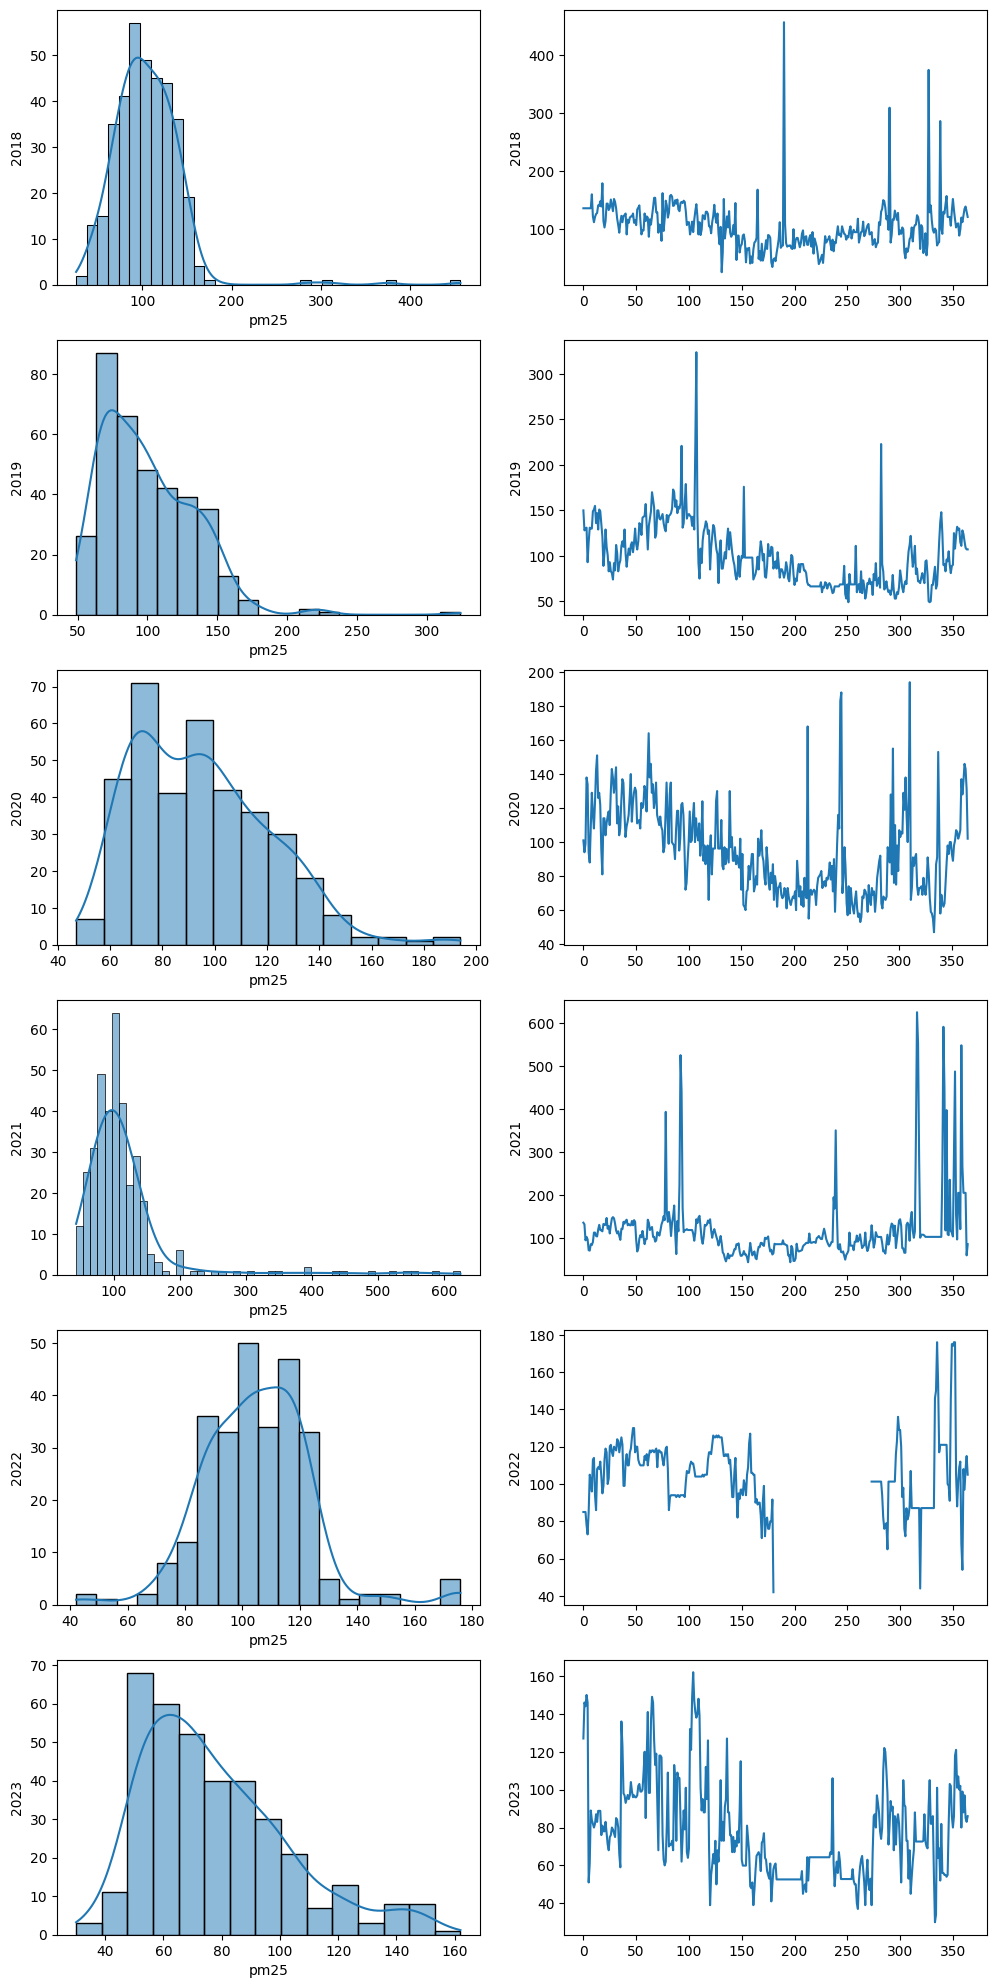

In [11]:
fig, ax = plt.subplots(6, 2, figsize = (12, 25))
for i, year in enumerate(range(2018, 2024)): 
    df = pd.read_csv(f'Data_blr_AQI/{year}.csv')
    sns.histplot(data = df,
                 x = 'pm25',
                 kde = True,
                 ax = ax[i][0])
    ax[i][1].plot(df['pm25'])
    ax[i][0].set_ylabel(year)
    ax[i][1].set_ylabel(year)

In [12]:
for year in range(2018, 2024):
    df = pd.read_csv(f'Data_blr_AQI/{year}.csv')
    print(year, *df.isna().sum())

2018 0 0
2019 0 0
2020 0 0
2021 0 0
2022 0 92
2023 0 0


**As it can be seen that there are missing values in 2022 dataset. Upon inspection, it was observed that the data for the month of July, August and September were missing.** <br>
To overcome this issue, the measures taken (either one of) - 
1. **Impute the missing values with the year-average (105.003297).**
2. The missing values correspond to `pm25` which is used in the AQI calculation. [(link)](https://airquality.cpcb.gov.in/ccr/#/caaqm-dashboard-all/caaqm-landing/aqi-repository)
3. Interpolate values from June to October

In [13]:
df_2022 = pd.read_csv('Data_blr_AQI/2022.csv', parse_dates=True, index_col='date')
# df_2022.loc[df_2022.index.month.isin([6,7,8])]

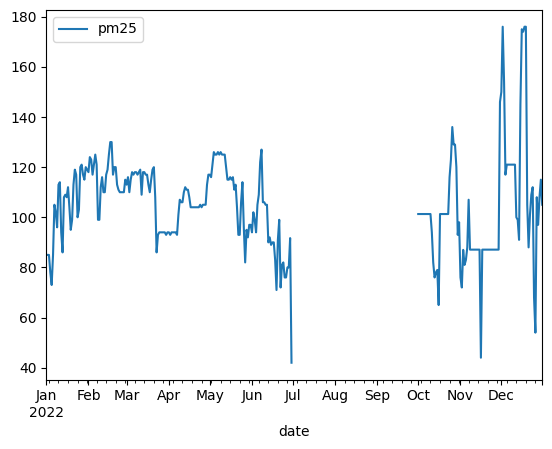

In [14]:
df_2022.plot(); 

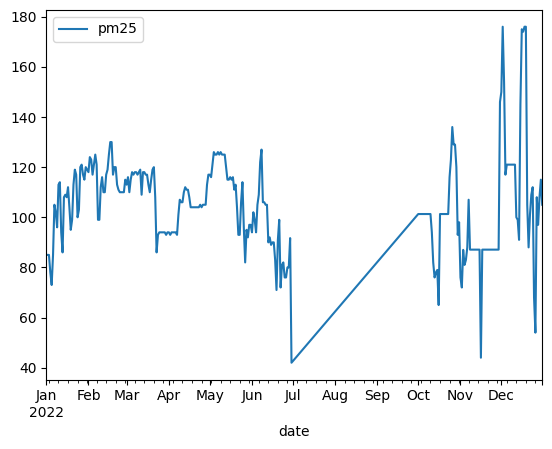

In [15]:
df_2022.interpolate().plot(); 

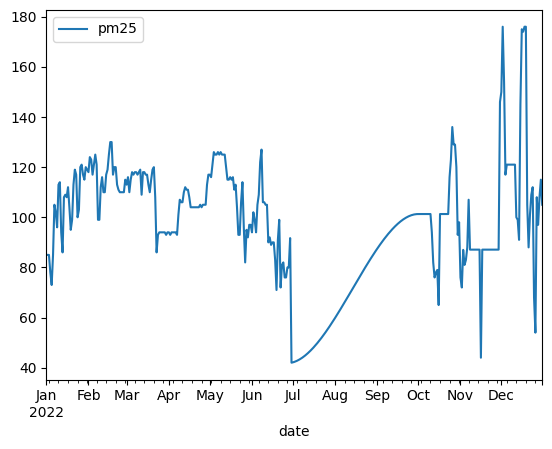

In [16]:
df_2022.interpolate(method='akima').plot(); 

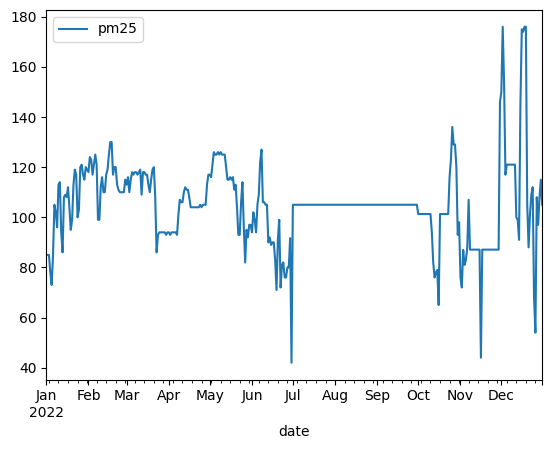

In [17]:
df_2022.fillna(df_2022.mean()).plot(); # We will using this approach

In [18]:
df_2022.fillna(df_2022.mean().round(1)).to_csv('Data_blr_AQI/2022.csv')